## <center> Project: Birmingham City Council Payments to Suppliers </center>

By Bashar Mohammad, 1 January 2022.

The data shows the individual payments made by Birmingham City Council to suppliers with a value over £500 over period between April 2020 and October 2021. In this notebook, we create insights out of the data.

- Which are the main spending departments of the council? What can be learned from their payment distribution?

- What are the the five top beneficiaries?

- What are the 10 top main beneficiaries which received payments from the department of Adult Social Care?

- When did the first expenditure start on Commonwealth games start?

- Which is the most popular beneficiary across the departments? and how much money does it receive in total?

 



https://data.birmingham.gov.uk/dataset/october-2021-payments-to-suppliers

In [1]:
clear all

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime


In [3]:
file_names=['january_2021.xlsx','may_2021.xlsx',
'april_2021.xlsx', 'july_2020.xlsx','october_2020.xlsx',
'august_2020.xlsx','july_2021.xlsx','october_2021.xlsx',
'august_2021.xlsx','june_2020.xlsx','september_2020.xlsx',
'june_2021.xlsx', 'september_2021.xlsx', 'november_2020.xlsx',
'december_2020.xlsx', 'march_2021.xlsx', 'february_2021.xlsx',
'may_2020.xlsx']

# Cleaning the data

It is obvious from the column names that there is a space at the end of the name of Department column, so we will rename it to "Department". Let us update the code used to concatenate the tables. 

In [4]:
df=pd.read_excel('april_2020.xlsx')
df = df.rename(columns={'Department ' : 'Department'})

for file_name in file_names:
    temp=pd.read_excel(file_name)
    
    # Those dataframes with a space at the end of the name of the Department column.
    temp = temp.rename(columns={'Department ' : 'Department'})

    df=pd.concat([df,temp],ignore_index=True)


In [5]:
df['Date']=pd.to_datetime(df['Date'])

Having looked at the date column, we realize that that there are two records which lie outside the period stated for this dataset. They corresponds dates are 6/1/2020 and 9/1/2020. It is more likely that such an error took place by accident and day and month should be exchanged. 

In [6]:
df['Date']=df['Date'].replace(datetime(2020,1,9),datetime(2020,9,1))

In [7]:
df['Date']=df['Date'].replace(datetime(2020,1,6),datetime(2020,6,1))

######  Let us sort the table in ascending order by the date column

In [8]:
df=df.sort_values('Date').reset_index()
df.head(3)

,index,Body,Date,Department,Beneficiary,Summary,Amount,Vendor Number,Unnamed: 7,Unnamed: 8,...,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18
0,2841,Birmingham City Council,2020-04-01,Neighbourhoods,CREATIVE COHESION WEST MIDLANDS,Grants To Vol Orgs,860.0,B138426,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,8037,Birmingham City Council,2020-04-01,Adults Social Care,NDH CARE LTD,HPDT/EAB OA,817.6,C103388,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3148,Birmingham City Council,2020-04-01,Education & Skills,DIRECT AUTOMATION LTD,Schools Delegated Budget,6912.0,B55569,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.columns

Index(['index', 'Body', 'Date', 'Department', 'Beneficiary', 'Summary',
       'Amount', 'Vendor Number', 'Unnamed: 7', 'Unnamed: 8',
       'Merchant Category', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15',
       'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'],
      dtype='object')

There are some unnecessary columns which need to be removed. 

In [10]:
df=df[[ 'Date', 'Department', 'Beneficiary', 'Summary',
       'Amount', 'Vendor Number']]

## Missing values

In [11]:
df.isnull().sum()

Date             0
Department       2
Beneficiary      0
Summary          3
Amount           0
Vendor Number    0
dtype: int64

In [12]:
df[df.Summary.isnull()]

,Date,Department,Beneficiary,Summary,Amount,Vendor Number
13761,2020-05-01,NaN,ACIVICO (DCFM) LIMITED,NaN,1329521.96,B145890
21587,2020-05-21,NaN,ACIVICO (DCFM) LIMITED,NaN,510149.33,B145890
150298,2021-03-29,CA-02996-03,BAMFORD BUS COMPANY LTD,NaN,658670.40,B145582


In [13]:
df.Department.unique()

array(['Neighbourhoods', 'Adults Social Care ', 'Education & Skills ',
       'Inclusive Growth', 'Finance & Governance', 'Chief Exec',
       'Digital & Customer', 'Human Resources ',
       'Partnerships Insight and Prevention', nan,
       'Commonwealth Games 2022', 'Education & Skills',
       'Skills & Education', 'Finance & Governance ',
       "Birmingham Children's Trust", 'CA-02996-03', 'CA-02700-04',
       'Commonwealth Games', 'Adults Social Care'], dtype=object)

From the unique values of the Department column, we can see that 'Skills & Education' and 'Education & Skills' are the same. 

'Finance & Governance ' has a white space at the end. Hence, We need to remove the space from the values in the Department column.

Also, The departments of "Commonwealth Games" and "Commonwealth Games 2022" in the Department column are the same, so we need to unify them.

In [14]:
df['Department'] = df['Department'].str.rstrip(' ')
df['Department'] = df['Department'].str.rstrip(' 2022')

In [15]:
df.Department=df.Department.replace('Skills & Education', 'Education & Skills')

#### Create a new column, namely 'year-month'

In [16]:
#df['year']=df['Date'].dt.year
#df['month']=df['Date'].dt.month
df['year-month']=df['Date'].dt.strftime('%y-%m')


### Which are the main spending departments of the council? What can be drawn from their payment distribution?


#### The statistical properties of the payment across the departments

In [55]:
df.groupby(['Department'])['Amount'].agg(['min', 'max','mean','median'])

,min,max,mean,median
Department,,,,
Adults Social Care,500.00,1371427.20,5422.691519,1710.240
Birmingham Children's Trust,834430.22,834430.22,834430.220000,834430.220
CA-02700-04,241920.00,241920.00,241920.000000,241920.000
CA-02996-03,658670.40,658670.40,658670.400000,658670.400
Chief Exec,500.00,2740636.75,47771.173957,2252.135
Commonwealth Games,4125.00,2833334.00,551527.339286,29850.000
Digital & Customer,500.00,4871375.95,36512.128637,5100.000
Education & Skills,500.00,20838774.25,6974.380877,1427.980
Finance & Governance,500.00,21386955.11,83576.916346,1800.000


From four statistical properties shown in the table above,  we can see that the departments of Birmingham Children's Trust, CA-02700-04 and CA-02996-03 made only a single payment in March 2021 to a single beneficiary.

As for the rest of the departments, we can realize that a small number of large payments pulled the mean above the median. Provided the wide range of payments for the latter, the median would be a more sensible average measure in this case.   

In [63]:
df[df.Department=="CA-02996-03"]

,Date,Department,Beneficiary,Summary,Amount,Vendor Number,year-month
150298,2021-03-29,CA-02996-03,BAMFORD BUS COMPANY LTD,NaN,658670.4,B145582,21-03


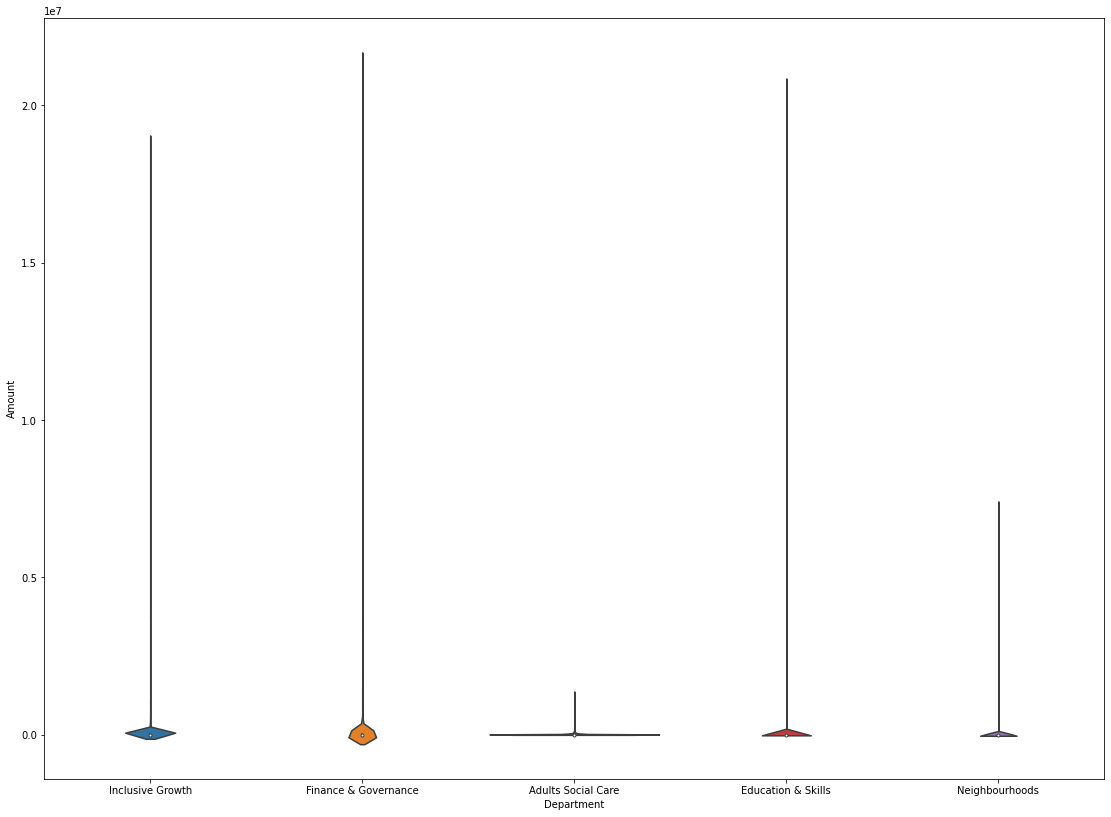

In [21]:
fig = plt.figure(figsize=(19,14))
ax = fig.subplots()

df_fi=df[(df['Department']=='Finance & Governance') | (df['Department']=='Education & Skills')|(df.Department=='Adults Social Care')| (df.Department=='Neighbourhoods') |(df.Department=='Inclusive Growth')]
order=df_fi.groupby(['Department'])['Amount'].median().sort_values(ascending=False).index

ax = sns.violinplot(x="Department", order=order,y="Amount", data=df_fi)

Obviosly, the main deprtments have a wide range of payments, but the difference between the median values is not much large. 

In [51]:
df_dep=df.groupby('Department')['Amount'].sum().sort_values(ascending=False).reset_index()
df_dep

,Department,Amount
0,Finance & Governance,9.896343e+08
1,Neighbourhoods,5.090560e+08
2,Adults Social Care,4.964528e+08
3,Education & Skills,4.898177e+08
4,Inclusive Growth,4.852216e+08
5,Digital & Customer,8.065529e+07
6,Partnerships Insight and Prevention,2.255578e+07
7,Chief Exec,1.328039e+07
8,Commonwealth Games,7.721383e+06
9,Human Resources,4.086658e+06


<AxesSubplot:ylabel='Amount'>

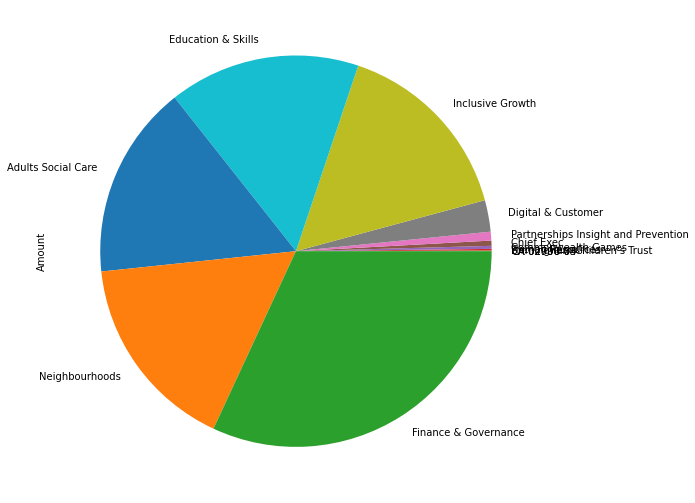

In [25]:
df_dep['Amount'].plot(kind='pie', figsize=(12,9))

The pie chart shows information about the total amount of money that Birmingham City Coucil spent on a wide range of sectors between April 2020 and October 2021. 

Just under a third of the total payments was made by the department of Finance and Governance, which is as twice as that made by each of the departments of Inclusive Growth, Education & Skills, Adults Social Care or Neighbours. CA-02700-04	 came last on the list with a quartor of a million.

In [26]:
df_finance=df[df['Department']=='Finance & Governance'].reset_index()
df_finance.head(3)

,index,Date,Department,Beneficiary,Summary,Amount,Vendor Number,year-month
0,11,2020-04-01,Finance & Governance,VENN GROUP LTD,Prop & Regen Team,1147.50,B34941,20-04
1,13,2020-04-01,Finance & Governance,BRAKE BROS LTD,Starbank Hobmoor Rd,779.36,B143373,20-04
2,14,2020-04-01,Finance & Governance,BRAKE BROS LTD,Wilkes Green Junior,773.89,B143373,20-04


<AxesSubplot:xlabel='year-month'>

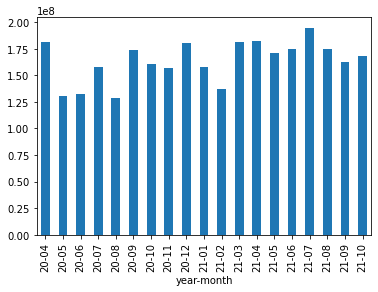

In [91]:
df.groupby('year-month')['Amount'].agg('sum').plot(kind='bar')

The total council's monthly payments to suppliers fluctuated over the whole period and peaked in July 2021 at 194 M

<AxesSubplot:xlabel='year-month'>

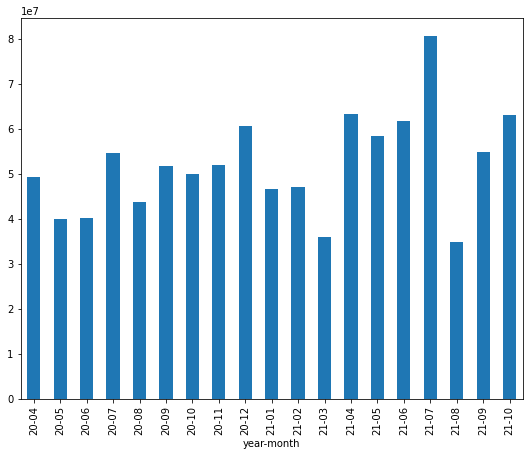

In [88]:
df_finance.groupby('year-month')['Amount'].agg('sum').plot(kind='bar',figsize=(9,7))

### Beneficiary

### What are the the five top beneficiaries?

In [78]:
df.groupby('Beneficiary')['Amount'].agg('sum').sort_values(ascending=False).head(5)

Beneficiary
BIRMINGHAM CHILDRENS TRUST CIC         4.121981e+08
LENDLEASE CONSTRUCTION (EUROPE) LTD    2.436567e+08
WATES CONSTRUCTION LTD                 1.361308e+08
BIRMINGHAM HIGHWAYS LTD                1.182077e+08
WILLMOTT DIXON PARTNERSHIPS LTD        8.535321e+07
Name: Amount, dtype: float64

BIRMINGHAM CHILDRENS TRUST CIC was the number-pne beneficiary, with 412 M, just ahead of LENDLEASE CONSTRUCTION (EUROPE) LTD. WATES CONSTRUCTION LTD was third on the list at 136 M.

###  What are the 10 top main beneficiaries which received payments from the department of Adult Social Care?

In [79]:
df[df.Department=='Adults Social Care'].groupby(['Beneficiary'])['Amount'].agg('sum').sort_values(ascending=False).reset_index().head(10)

,Beneficiary,Amount
0,MEDEQUIP ASSISTIVE TECHNOLOGY LTD,9962086.58
1,CARETECH COMMUNITY SERVICES,9618747.29
2,SEVACARE UK LTD,9426397.96
3,REDACTED - PERSONAL DATA,9185781.96
4,MACC CARE LTD,8947543.85
5,TRIDENT REACH THE PEOPLE CHARITY,7783059.21
6,THE RIDINGS CARE HOME,7443842.33
7,LIFEWAYS COMMUNITY CARE LTD,7016778.76
8,VOYAGE,6516924.27
9,HAYS SPECIALIST RECRUITMENT LTD,6354232.22


In [80]:
df_ct=df[df['Beneficiary']=='BIRMINGHAM CHILDRENS TRUST CIC'].reset_index()

<AxesSubplot:xlabel='year-month'>

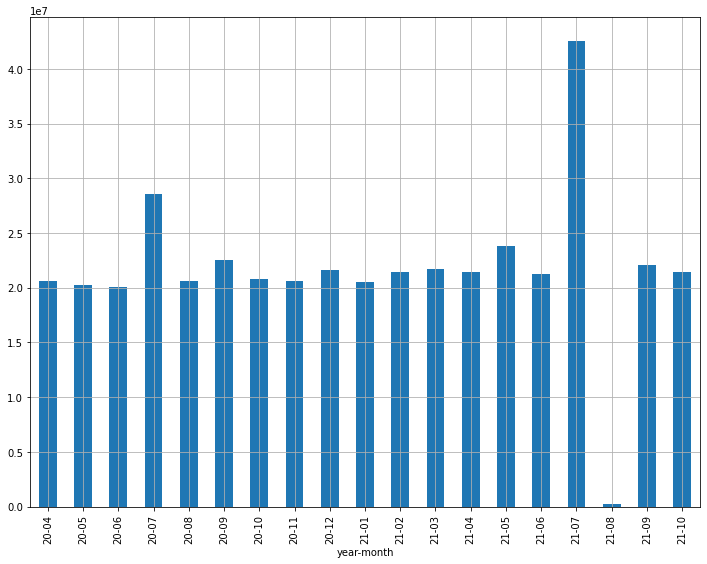

In [81]:
df_ct.groupby('year-month')['Amount'].agg('sum').plot(kind='bar',grid=True,figsize=(12,9))

The chart shows data about the monthly payment Birmingham City Council paid BIRMINGHAM CHILDRENS TRUST CIC between April 2020 and October 2021. 

Having remained stable at approximately £21 M between August 2020 and June 2021, the figure rose sharply and doubled in July 2021, reaching nearly 45 M.  The monthly payment dropped significantly to about 0.27 M before it levelled off again to finish at around 21 M. 

In [31]:
df_ct.groupby('year-month')['Amount'].agg('sum')

year-month
20-04    20582518.76
20-05    20219077.16
20-06    20106862.90
20-07    28540346.90
20-08    20628678.45
20-09    22569478.74
20-10    20775038.45
20-11    20600338.32
20-12    21578036.85
21-01    20567755.82
21-02    21467542.89
21-03    21690864.58
21-04    21466659.42
21-05    23780968.21
21-06    21296088.00
21-07    42561489.56
21-08      276322.36
21-09    22049554.04
21-10    21440469.65
Name: Amount, dtype: float64

### Commonwealth Games

<AxesSubplot:xlabel='year-month'>

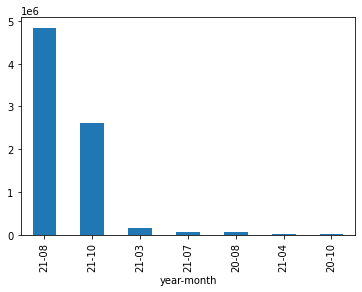

In [84]:
df[df['Department']=='Commonwealth Games'].groupby('year-month')['Amount'].agg('sum').sort_values(ascending=False).plot(kind='bar')

The department of Commonwealth Games made irregular payments to suppliers. 

In [33]:
df[df['Department']=='Commonwealth Games'].groupby(['Beneficiary','year-month'])['Amount'].agg('sum')

Beneficiary                          year-month
ACIVICO (DCFM) LTD                   21-08            7036.80
                                     21-10            5273.90
ENV (COVENTRY) C.I.C                 21-04            9720.00
                                     21-07            6480.00
HAYSTOUN CONSTRUCTION LTD            21-10          100844.20
LOCALITY (UK)                        21-07           49980.00
MCLEAN PROJECTS AND EVENTS LTD       20-10            4125.00
                                     21-03            5625.00
                                     21-04            6000.00
OVE ARUP & PARTNERS LTD              20-08           54000.00
SANDWELL METROPOLITAN BOROUGH COUNC  21-08         4833334.00
                                     21-10         2500000.00
WESTERN POWER DISTRIBUTION (WMIDS)   21-03          138963.85
Name: Amount, dtype: float64

The tables show that the expenditure on Commonwealth Games started in August 2020. SANDWELL METROPOLITAN BOROUGH COUNC received the first and second highest payments from the council in August and October, 2021 at about 4.8  and 2.5 M respectively. 

###  Which is the most popular beneficiary across the departments? and how much money does it receive in total?

In [34]:
df_popular=df.groupby(['Department']).agg(mod  = ('Beneficiary', \
                                        lambda x: x.value_counts().index[0]),
                                    
                                      ).reset_index()

df_popular

,Department,mod
0,Adults Social Care,SEVACARE (UK) LTD
1,Birmingham Children's Trust,VEOLIA ES BIRMINGHAM LTD
2,CA-02700-04,PARADISE CIRCUS GENERAL PARTNER LTD
3,CA-02996-03,BAMFORD BUS COMPANY LTD
4,Chief Exec,BT REDCARE
5,Commonwealth Games,SANDWELL METROPOLITAN BOROUGH COUNC
6,Digital & Customer,REDACTED - PERSONAL DATA
7,Education & Skills,TOTAL GAS & POWER LTD
8,Finance & Governance,REDACTED - PERSONAL DATA
9,Human Resources,OH DEPARTMENT LTD


In [35]:
zip(df_popular['Department'], df_popular['mod'])

In [45]:
total=[]
for u,v in zip(df_popular['Department'], df_popular['mod']):
    total.append(df[(df['Department']==u)& (df['Beneficiary']==v)]['Amount'].agg('sum'))

In [47]:
df_popular['Total_Amount']=total

In [50]:
df_popular.sort_values('Total_Amount', ascending=False)

,Department,mod,Total_Amount
10,Inclusive Growth,TOTAL GAS & POWER LTD,30647484.70
11,Neighbourhoods,EXTRA PERSONNEL,20095653.64
5,Commonwealth Games,SANDWELL METROPOLITAN BOROUGH COUNC,7333334.00
0,Adults Social Care,SEVACARE (UK) LTD,5876377.76
7,Education & Skills,TOTAL GAS & POWER LTD,5813238.34
8,Finance & Governance,REDACTED - PERSONAL DATA,2620900.20
1,Birmingham Children's Trust,VEOLIA ES BIRMINGHAM LTD,834430.22
12,Partnerships Insight and Prevention,G2V RECRUITMENT GROUP LTD,825178.80
3,CA-02996-03,BAMFORD BUS COMPANY LTD,658670.40
2,CA-02700-04,PARADISE CIRCUS GENERAL PARTNER LTD,241920.00


In [85]:
df.Amount.sum()

3102056676.96

### Conclusion

The data used in this notebook shows how Birmingham City Council spent their money over the period between April 2020 and October 2021. The total amount of money the council spent is about 3.1 billions.

Looking at the details, The total council's monthly payments to suppliers fluctuated over the whole period and peaked in July 2021 at 194 M.

The much higher mean in some departments indicates that some high payments were made to suppliers. Also, there are three departments which only made a single payment in March 2020. 


Just under a third of the total payments was made by the department of Finance and Governance, which is as twice as that made by each of the departments of Inclusive Growth, Education & Skills, Adults Social Care or Neighbours. CA-02700-04	 came last on the list with a quartor of a million.
